**With Traffic light**

Episode 1/100 completed. Total reward: -1482.2
Episode 2/100 completed. Total reward: 5084.000000000003
Episode 3/100 completed. Total reward: 4737.200000000001
Episode 4/100 completed. Total reward: 3959.600000000004
Episode 5/100 completed. Total reward: 3872.400000000003
Episode 6/100 completed. Total reward: 3740.6000000000017
Episode 7/100 completed. Total reward: 3683.4000000000015
Episode 8/100 completed. Total reward: 4091.2
Episode 9/100 completed. Total reward: 3335.0000000000014
Episode 10/100 completed. Total reward: 4430.600000000001
Episode 11/100 completed. Total reward: 3832.600000000002
Episode 12/100 completed. Total reward: 3801.2000000000016
Episode 13/100 completed. Total reward: 4234.400000000002
Episode 14/100 completed. Total reward: 4220.600000000005
Episode 15/100 completed. Total reward: 4036.0000000000027
Episode 16/100 completed. Total reward: 3960.800000000002
Episode 17/100 completed. Total reward: 3701.8000000000034
Episode 18/100 completed. Total reward

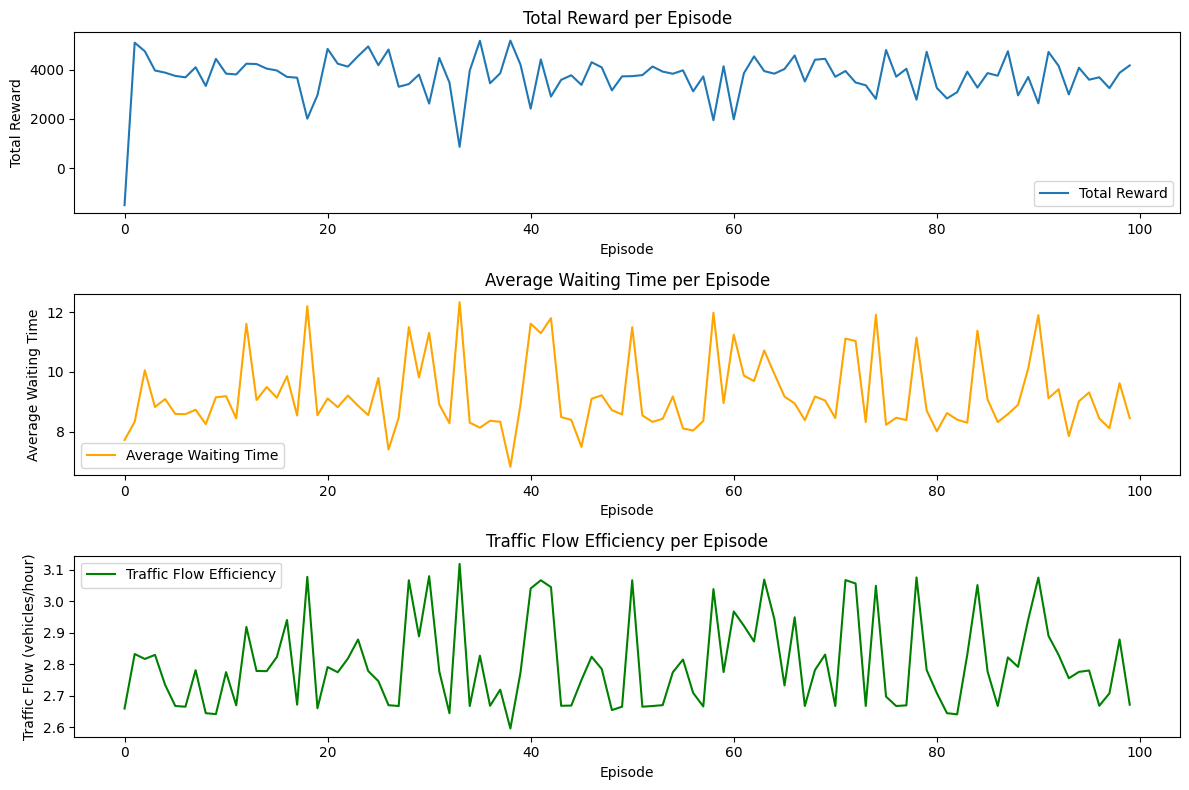

In [2]:
import traci
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

# DQN parameters
ALPHA = 0.005
GAMMA = 0.99
EPSILON = 0.1
MAX_EPISODES = 100
ACTIONS = ["green", "yellow", "red"]
STATE_SIZE = 4 # High density, Ramp queue length, Traffic light state
ACTION_SIZE = len(ACTIONS)
BUFFER_SIZE = 20000
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# Experience replay buffer
experience_replay = deque(maxlen=BUFFER_SIZE)

# Define the Q-network (Neural Network)
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize the Q-network and optimizer
q_network = QNetwork(STATE_SIZE, ACTION_SIZE)
optimizer = optim.Adam(q_network.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

def get_state():
    """Normalized state representation"""
    highway_density = len(traci.edge.getLastStepVehicleIDs("2to3")) / 15.0
    ramp_queue = len(traci.edge.getLastStepVehicleIDs("intramp")) / 10.0
    waiting_time = traci.edge.getWaitingTime("intramp") / 100.0  # New feature
    light_state = traci.trafficlight.getRedYellowGreenState("node6")
    light_index = {"G": 0, "y": 0.5, "r": 1}.get(light_state, 1)
    return np.array([highway_density, ramp_queue, waiting_time, light_index], dtype=np.float32)




def take_action(action):
    """Apply action to traffic light node6"""
    if action == 0:
        traci.trafficlight.setRedYellowGreenState("node6", "G")
    elif action == 1:
        traci.trafficlight.setRedYellowGreenState("node6", "y")
    elif action == 2:
        traci.trafficlight.setRedYellowGreenState("node6", "r")
def get_action(state):
    """
    Epsilon-greedy action selection
    """
    if random.uniform(0, 1) < EPSILON:
        return random.randint(0, ACTION_SIZE - 1)  # Subtract 1 to get valid index range
    
    state_tensor = torch.from_numpy(state).float().unsqueeze(0)
    with torch.no_grad():
        q_values = q_network(state_tensor)
    return torch.argmax(q_values).item()

def get_reward(state, action):
    """Modified reward function focusing on reducing waiting time"""
    ramp_queue = len(traci.edge.getLastStepVehicleIDs("intramp"))
    highway_density = len(traci.edge.getLastStepVehicleIDs("2to3"))
    waiting_time = traci.edge.getWaitingTime("intramp")
    
    reward = 0
    # Stronger penalties for waiting time and queue
    reward -= waiting_time * 0.2  # Increased penalty
    reward -= ramp_queue * 3      # Increased penalty
    
    # Reward for good actions
    if action == 0 and ramp_queue > 0:  # Green when queue exists
        reward += 25  # Increased reward
    elif action == 2 and highway_density > 10:  # Red when congested
        reward += 15
    elif action == 1:  # Discourage unnecessary yellow
        reward -= 10
        
    return reward

def calculate_traffic_flow():
    """Calculate traffic flow on main road and ramp"""
    highway_flow = len(traci.edge.getLastStepVehicleIDs("2to3"))
    ramp_flow = len(traci.edge.getLastStepVehicleIDs("intramp"))
    return highway_flow + ramp_flow

def calculate_average_waiting_time():
    """Modified waiting time calculation"""
    waiting_time = traci.edge.getWaitingTime("intramp")
    num_vehicles = max(len(traci.edge.getLastStepVehicleIDs("intramp")), 1)
    return waiting_time / num_vehicles
# Store metrics for visualization
total_rewards = []
average_waiting_times = []
traffic_flows = []


def train_dqn():
    global total_rewards, average_waiting_times, traffic_flows

    for episode in range(MAX_EPISODES):
        traci.start(["sumo", "-c", "D:/3CS/RL/rl for ramp metering/sumo/mynet.sumocfg"])
        state = get_state()
        done = False
        episode_reward = 0  # Cumulative reward for the episode
        waiting_times = []  # Track waiting times
        flows = []  # Track traffic flows

        while not done:
            action = get_action(state)
            take_action(action)
            traci.simulationStep()

            next_state = get_state()
            reward = get_reward(state, action)
            episode_reward += reward  # Accumulate reward

            # Track metrics
            waiting_times.append(calculate_average_waiting_time())
            flows.append(calculate_traffic_flow())

            # Store experience in replay buffer
            experience_replay.append((state, action, reward, next_state, done))

            if len(experience_replay) >= BATCH_SIZE:
                batch = random.sample(experience_replay, BATCH_SIZE)
                states, actions, rewards, next_states, dones = zip(*batch)
                states = torch.from_numpy(np.array(states, dtype=np.float32))
                actions = torch.tensor(actions)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                next_states = torch.from_numpy(np.array(next_states, dtype=np.float32))
                dones = torch.tensor(dones, dtype=torch.float32)

                q_values = q_network(states)
                next_q_values = q_network(next_states).detach()
                target_q_values = rewards + GAMMA * torch.max(next_q_values, dim=1)[0] * (1 - dones)
                current_q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

                loss = criterion(current_q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            if traci.simulation.getMinExpectedNumber() == 0:
                done = True

        total_rewards.append(episode_reward)
        average_waiting_times.append(np.mean(waiting_times))
        traffic_flows.append(np.mean(flows))

        print(f"Episode {episode + 1}/{MAX_EPISODES} completed. Total reward: {episode_reward}")
        
        traci.close()
        # Add after training loop but before plotting
        model_save_path = "D:/3CS/RL/rl for ramp metering/models/dqn_weights.pth"
        torch.save({
            'model_state_dict': q_network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'episode_rewards': total_rewards,
            'waiting_times': average_waiting_times,
            'traffic_flows': traffic_flows
        }, model_save_path)

# Train the DQN model
train_dqn()

# Visualize metrics
plt.figure(figsize=(12, 8))

# Total Reward
plt.subplot(3, 1, 1)
plt.plot(total_rewards, label="Total Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.legend()

# Average Waiting Time
plt.subplot(3, 1, 2)
plt.plot(average_waiting_times, label="Average Waiting Time", color="orange")
plt.xlabel("Episode")
plt.ylabel("Average Waiting Time")
plt.title("Average Waiting Time per Episode")
plt.legend()

# Traffic Flow Efficiency
plt.subplot(3, 1, 3)
plt.plot(traffic_flows, label="Traffic Flow Efficiency", color="green")
plt.xlabel("Episode")
plt.ylabel("Traffic Flow (vehicles/hour)")
plt.title("Traffic Flow Efficiency per Episode")
plt.legend()

plt.tight_layout()  
plt.show()


**Without Traffic light**

c:\Users\Amraoui Khireddine\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Episode 1/100 completed. Total reward: -4912.800000000001
Episode 2/100 completed. Total reward: 4040.000000000005
Episode 3/100 completed. Total reward: 4529.600000000002
Episode 4/100 completed. Total reward: 3541.0000000000023
Episode 5/100 completed. Total reward: 3569.200000000004
Episode 6/100 completed. Total reward: 3608.2000000000053
Episode 7/100 completed. Total reward: 3338.8000000000034
Episode 8/100 completed. Total reward: 3958.8000000000025
Episode 9/100 completed. Total reward: 3931.8000000000006
Episode 10/100 completed. Total reward: 3926.6000000000026
Episode 11/100 completed. Total reward: 3915.800000000003
Episode 12/100 completed. Total reward: 3928.000000000003
Episode 13/100 completed. Total reward: 3799.0000000000036
Episode 14/100 completed. Total reward: 3776.0000000000036
Episode 15/100 completed. Total reward: 4073.2000000000016
Episode 16/100 completed. Total reward: 3858.4000000000037
Episode 17/100 completed. Total reward: 3715.8000000000034
Episode 18/

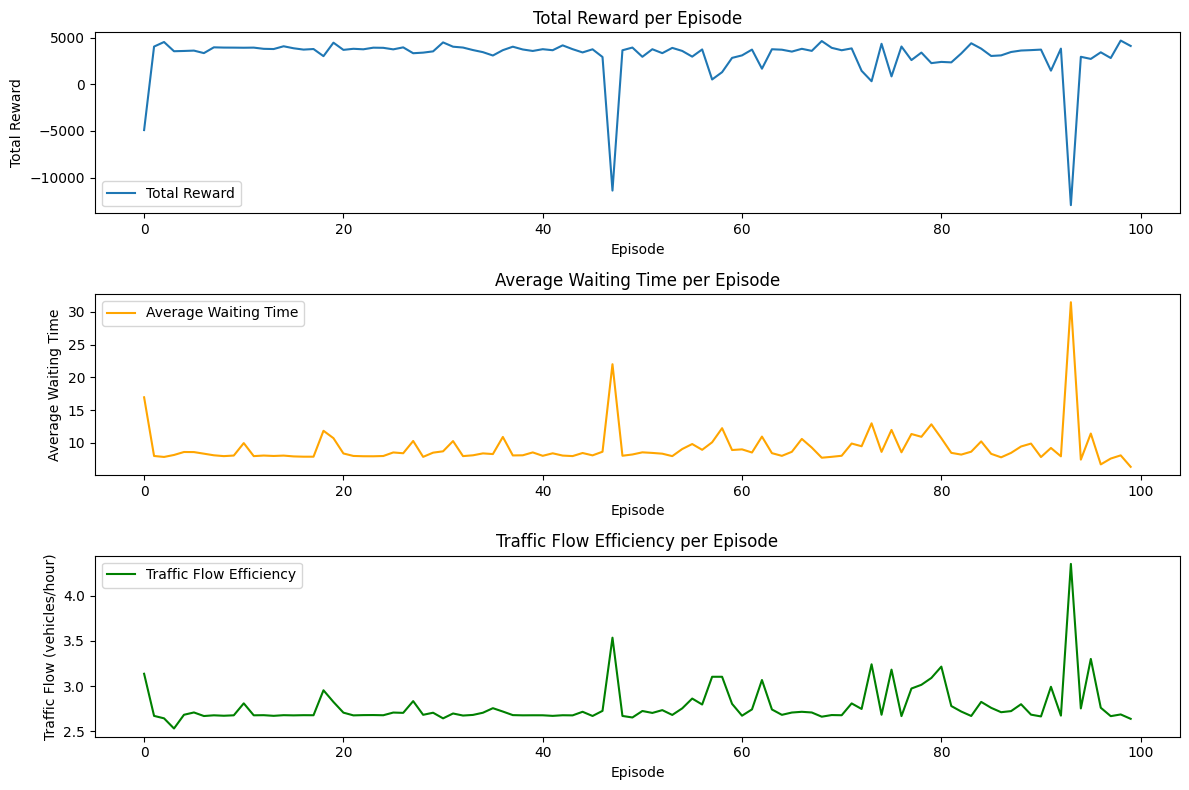

In [ ]:
import traci
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

# DQN parameters
ALPHA = 0.005
GAMMA = 0.99
EPSILON = 0.1
MAX_EPISODES = 100
STATE_SIZE = 3  # highway_density, ramp_queue, waiting_time
ACTION_SIZE = 2  # allow/block
BUFFER_SIZE = 20000
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# Experience replay buffer
experience_replay = deque(maxlen=BUFFER_SIZE)

# Define the Q-network (Neural Network)
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize the Q-network and optimizer
q_network = QNetwork(STATE_SIZE, ACTION_SIZE)
optimizer = optim.Adam(q_network.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

def get_state():
    """Normalized state representation without traffic light"""
    highway_density = len(traci.edge.getLastStepVehicleIDs("2to3")) / 15.0
    ramp_queue = len(traci.edge.getLastStepVehicleIDs("intramp")) / 10.0
    waiting_time = traci.edge.getWaitingTime("intramp") / 100.0
    return np.array([highway_density, ramp_queue, waiting_time], dtype=np.float32)

def take_action(action):
    """Ramp metering action"""
    ramp_vehicles = traci.edge.getLastStepVehicleIDs("intramp")
    for vehicle in ramp_vehicles:
        if action == 0:  # Allow
            traci.vehicle.setSpeed(vehicle, 13.89)  # 50 km/h
        else:  # Block
            traci.vehicle.setSpeed(vehicle, 0)

def get_action(state):
    """Epsilon-greedy action selection"""
    if random.uniform(0, 1) < EPSILON:
        return random.randint(0, ACTION_SIZE - 1)
    
    state_tensor = torch.from_numpy(state).float().unsqueeze(0)
    with torch.no_grad():
        q_values = q_network(state_tensor)
    return torch.argmax(q_values).item()

def get_reward(state, action):
    """Reward function focusing on reducing waiting time"""
    ramp_queue = len(traci.edge.getLastStepVehicleIDs("intramp"))
    highway_density = len(traci.edge.getLastStepVehicleIDs("2to3"))
    waiting_time = traci.edge.getWaitingTime("intramp")
    
    reward = 0
    # Stronger penalties for waiting time and queue
    reward -= waiting_time * 0.2  # Increased penalty
    reward -= ramp_queue * 3      # Increased penalty
    
    # Reward for good actions
    if action == 0 and ramp_queue > 0:  # Allow when queue exists
        reward += 25  # Increased reward
    elif action == 1 and highway_density > 10:  # Block when congested
        reward += 15
        
    return reward
def calculate_traffic_flow():
    """Calculate traffic flow on main road and ramp"""
    highway_flow = len(traci.edge.getLastStepVehicleIDs("2to3"))
    ramp_flow = len(traci.edge.getLastStepVehicleIDs("intramp"))
    return highway_flow + ramp_flow

def calculate_average_waiting_time():
    """Modified waiting time calculation"""
    waiting_time = traci.edge.getWaitingTime("intramp")
    num_vehicles = max(len(traci.edge.getLastStepVehicleIDs("intramp")), 1)
    return waiting_time / num_vehicles
# Store metrics for visualization
total_rewards = []
average_waiting_times = []
traffic_flows = []



def train_dqn():
    global total_rewards, average_waiting_times, traffic_flows

    for episode in range(MAX_EPISODES):
        traci.start(["sumo", "-c", "D:/3CS/RL/rl for ramp metering/sumo/mynet.sumocfg"])
        state = get_state()
        done = False
        episode_reward = 0  # Cumulative reward for the episode
        waiting_times = []  # Track waiting times
        flows = []  # Track traffic flows

        while not done:
            action = get_action(state)
            take_action(action)
            traci.simulationStep()

            next_state = get_state()
            reward = get_reward(state, action)
            episode_reward += reward  # Accumulate reward

            # Track metrics
            waiting_times.append(calculate_average_waiting_time())
            flows.append(calculate_traffic_flow())

            # Store experience in replay buffer
            experience_replay.append((state, action, reward, next_state, done))

            if len(experience_replay) >= BATCH_SIZE:
                batch = random.sample(experience_replay, BATCH_SIZE)
                states, actions, rewards, next_states, dones = zip(*batch)
                states = torch.from_numpy(np.array(states, dtype=np.float32))
                actions = torch.tensor(actions)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                next_states = torch.from_numpy(np.array(next_states, dtype=np.float32))
                dones = torch.tensor(dones, dtype=torch.float32)

                q_values = q_network(states)
                next_q_values = q_network(next_states).detach()
                target_q_values = rewards + GAMMA * torch.max(next_q_values, dim=1)[0] * (1 - dones)
                current_q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

                loss = criterion(current_q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            if traci.simulation.getMinExpectedNumber() == 0:
                done = True

        total_rewards.append(episode_reward)
        average_waiting_times.append(np.mean(waiting_times))
        traffic_flows.append(np.mean(flows))

        print(f"Episode {episode + 1}/{MAX_EPISODES} completed. Total reward: {episode_reward}")

        traci.close()
    # Save model
    torch.save({
        'model_state_dict': q_network.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'total_rewards': total_rewards,
        'average_waiting_times': average_waiting_times,
        'traffic_flows': traffic_flows
    }, "D:/3CS/RL/rl for ramp metering/models/no_traffic_light_dqn.pth")


# Train the DQN model
train_dqn()

# Visualize metrics
plt.figure(figsize=(12, 8))

# Total Reward
plt.subplot(3, 1, 1)
plt.plot(total_rewards, label="Total Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.legend()

# Average Waiting Time
plt.subplot(3, 1, 2)
plt.plot(average_waiting_times, label="Average Waiting Time", color="orange")
plt.xlabel("Episode")
plt.ylabel("Average Waiting Time")
plt.title("Average Waiting Time per Episode")
plt.legend()

# Traffic Flow Efficiency
plt.subplot(3, 1, 3)
plt.plot(traffic_flows, label="Traffic Flow Efficiency", color="green")
plt.xlabel("Episode")
plt.ylabel("Traffic Flow (vehicles/hour)")
plt.title("Traffic Flow Efficiency per Episode")
plt.legend()

plt.tight_layout()  
plt.show()